# Gradient boosting machine
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st
from itertools import combinations

In [2]:
model_name = "gbm"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Use randomised search to find optimal hyperparameters. This model will take about 5 minutes to train. The quality of the solution may be improved by increasing the number of iterations in the randomized search, at the expense of increased training times.

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
regr = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [5]:
param_dist = {'n_estimators': st.randint(3, 100),
                'learning_rate': st.uniform(0.01, 0.1),
                'max_depth': range(2,31),
                'min_samples_leaf': st.randint(1, 100),
                'min_samples_split': st.randint(2, 50),
                'max_features': range(3,X.shape[1]+1),
                'subsample': st.uniform(0.1, 0.9)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=50,
            cv=tscv,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.4min finished


Pipeline(memory=None,
     steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
         ...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [6]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [7]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
15,44.351960,0.136170,-2688.519438,-156.850716,0.0824732,14,13,2,22,77,...,-3681.026355,-160.248166,-2170.655630,-152.609939,-2213.876330,-157.694042,27.071371,0.018756,702.030148,3.174799
7,32.673060,0.077666,-3010.243516,-831.606545,0.0980085,30,17,13,44,49,...,-4358.536044,-1022.801499,-2322.806491,-795.465142,-2349.388013,-676.552994,22.541127,0.017294,953.448548,143.646923
29,9.537623,0.055002,-3236.917845,-1594.578023,0.106838,13,12,14,49,59,...,-4904.647135,-2018.520556,-2446.402004,-1488.187218,-2359.704397,-1277.026296,5.868050,0.006378,1179.793727,311.921664
30,20.943054,0.087167,-3366.962101,-1882.302503,0.0642945,14,14,34,10,75,...,-5207.191743,-2434.556790,-2505.625801,-1776.511432,-2388.068759,-1435.839287,13.225809,0.017437,1302.123590,414.530237
18,25.686952,0.108839,-3398.293809,-1835.797073,0.0645822,18,14,39,9,75,...,-5244.028587,-2400.874651,-2497.719389,-1705.896468,-2453.133450,-1400.620100,15.904758,0.040549,1305.258501,418.555386


Inspect the pairwise distribution of cross validation scores. Darker shades of blue indicate superior performance while the red star represents the optimal solution found.

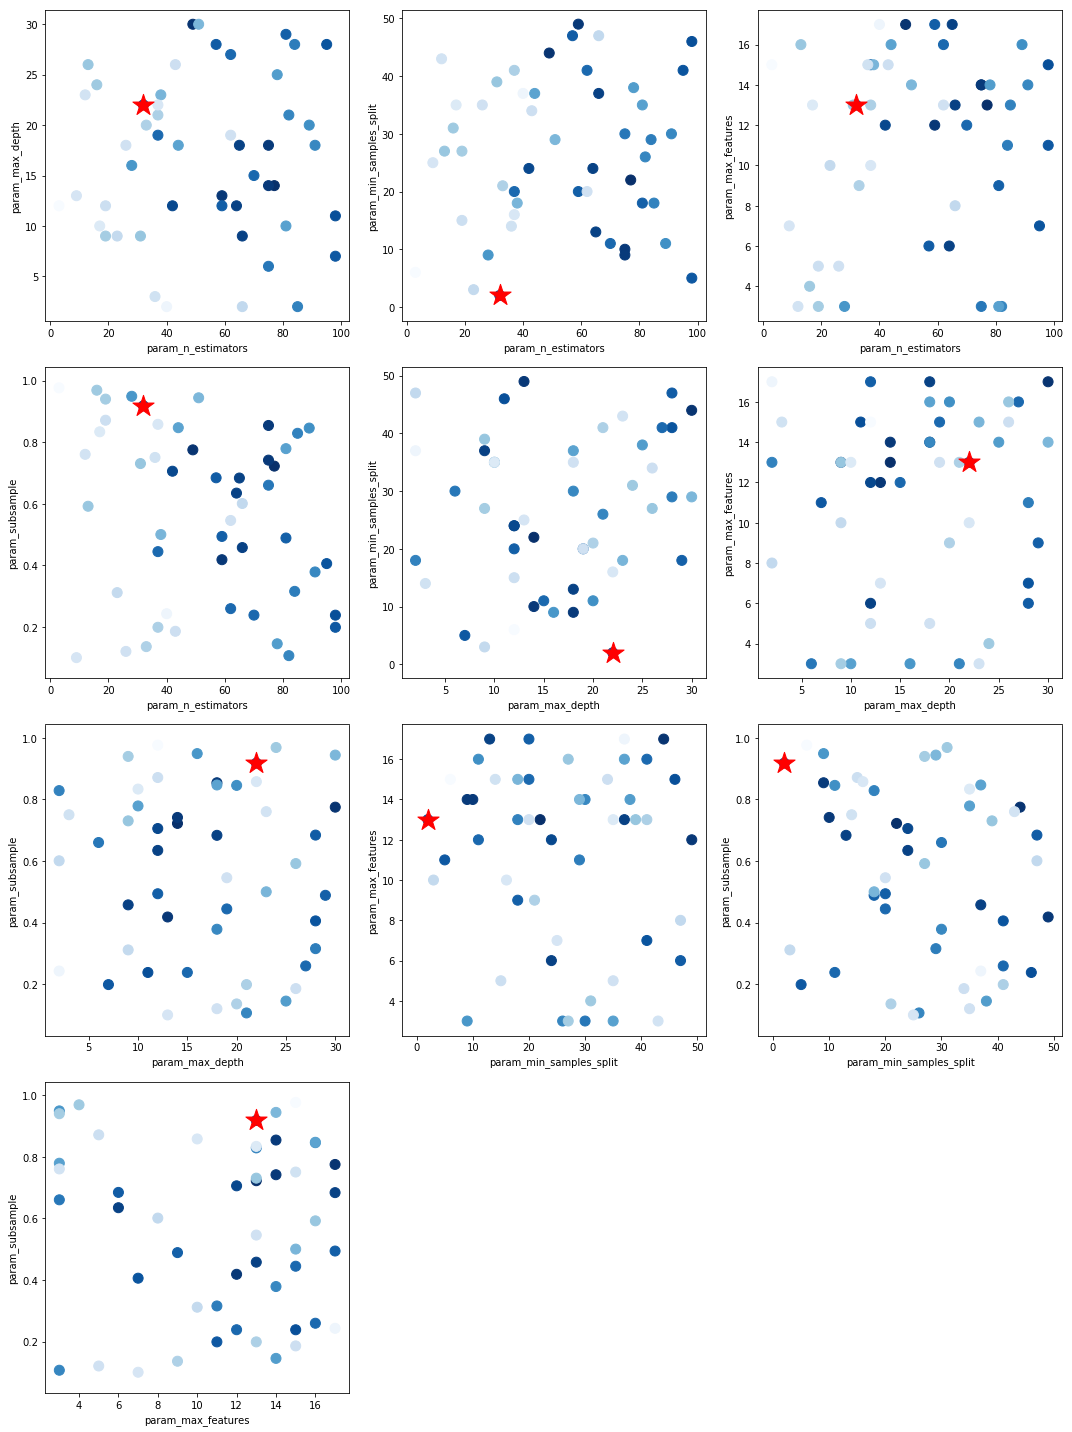

In [24]:
params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_max_features', 'param_subsample']
gs = gridspec.GridSpec(4,3)
fig = plt.figure(figsize=(15, 20), tight_layout=True)
plt_best = cv_results.loc[[0]]
for idx, params in enumerate(combinations(params, 2)):
    ax = fig.add_subplot(gs[idx])
    plt.scatter(cv_results[params[0]], cv_results[params[1]], c=-np.log(-cv_results['mean_test_score']), s=100, cmap="Blues")
    plt.scatter(plt_best[params[0]], plt_best[params[1]], s=500, marker="*", c="r")
    plt.xlabel(params[0])
    plt.ylabel(params[1])

Inspect feature importance

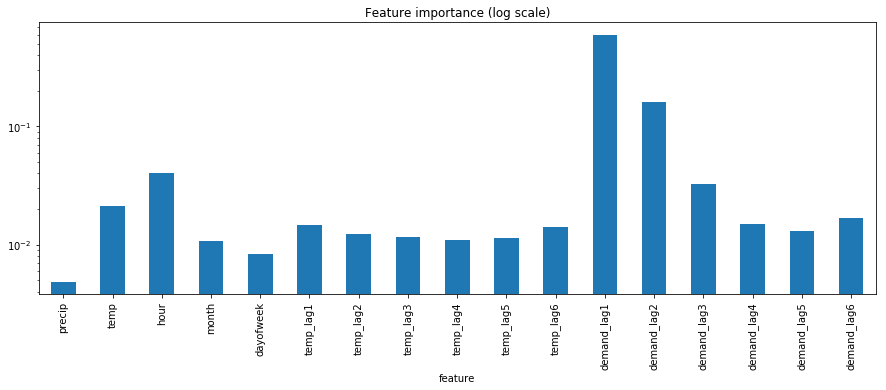

In [25]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5), logy=True, title='Feature importance (log scale)', legend=False)
plt.show()